# 0. Goal, Purpose, and possible insights

The goal of this notebook is to find factors which influence daily sales, and how they do so. With the purpose of obtaining actionable insights which can be used to improve store sales or reduce costs

Ideas of possible insights
- Predict if a certain store is worth opening on a certain day
- Predict if a product family may be a worthy addition to a certain store
- find cases in which a product family / store is underpeforming and could see gains from an investigation and taking actionable meassures.
- find the effectivity of product sales in increasing sales.


Ideas of insights that may be less cost effective to gather:
- predict the increase/decrease on sales of a certain product family per stock per time: Analysis is complex, and of limited value since different products of the same family may behave differently.

Currently inusable/impossible insights:
- find a baseline to compare how a normal product of a certain family is behaving, so that products can be compared to this baseline in the future: Inusable because we only have data agregated per product family.
- predict the necessary stock of a certain item (per store and product family): Impossible because we only have data agregated per product family.


# 1. Setup

In [47]:
import data_preparation_attempt4 as data_prep
from sklearn.pipeline import FunctionTransformer
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

#By default i recommend using hvplot for graphing:
#call it with hvPlot(df).graphtype 
#Its an alternative to df.plot, sns.charttype and px.charttype . It has good performance, unlike plotly in my experience, and short synthax (like sns and px) but creates interactive graphs. 
#It uses bokeh in the backend by default. Bokeh has a beautiful synthax to build graphs, and great performance but is a bit verbose.
import hvplot.pandas #could be used instead to be able to use df.hvplot but it wont have tab completion
#, use it instead of plotly to have higher performance easy to create graphs. 
#It will use bokeh in the backend by default, which is a bit verbose to use directly.
from hvplot import hvPlot 
import holoviews as hv #All hvplots are returned inside a holoview layout. hv.Layout([plots_list]) can also be used to plot an array of plots together in one figure

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bokeh.plotting import figure, show

#Reload all modules imported with %aimport every time before executing the Python code typed. https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload explicit
%aimport data_preparation_attempt4

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns',1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def describe_basics(table, number_of_examples=1) -> pd.DataFrame:
      description_table = table.head(number_of_examples).T.add_prefix('example_')
      description_table['type'] = table.dtypes
      description_table['nulls'] = table.isna().sum()
      description_table['unique'] = table.nunique()
      description_table['total rows'] = len(table) 
      description_table.columns = description_table.columns.rename('columns')
      return description_table

def describe_categoricals(table, number_of_examples=1) -> pd.DataFrame:
      if len(table.columns)>0: 
            table = table.select_dtypes(['object', 'datetime', 'datetimetz', 'timedelta', 'category'])
            description_table = describe_basics(table, number_of_examples=number_of_examples)
            categorical_describe = table.describe(include=['object', 'datetime', 'datetimetz', 'timedelta', 'category']).T
            description_table['most_common'] = categorical_describe['top']
            description_table['freq_of_most_common'] = categorical_describe['freq']
            return description_table
      return None

def describe_numericals(table, number_of_examples=1) -> pd.DataFrame: 
      table = table.select_dtypes(['number'])
      if len(table.columns)>0: 
            description_table = describe_basics(table, number_of_examples)
            numerical_describe = table.describe().T
            description_table['mean'] = numerical_describe['mean']
            description_table['std'] = numerical_describe['std']
            description_table['min'] = numerical_describe['min']
            description_table['25%'] = numerical_describe ['25%']
            description_table['50%'] = numerical_describe['50%']
            description_table['75%'] = numerical_describe['75%']
            description_table['max'] = numerical_describe['max']
            return description_table
      return None

def display_table_description(table:pd.DataFrame, number_of_examples=1) ->None:
      display(describe_categoricals(table, number_of_examples))
      display(describe_numericals(table, number_of_examples))
      #Display algun branch graph de transaction_data.value_counts() ? Un decompostion tree
      # No parece tener seaborn
      # Parece ser posible pero dificil en plotly
      #https://community.plotly.com/t/decision-tree-plot-plot-tree/68403/6
      #https://plotly.com/python/tree-plots/
      #Un treemap es mas feucho pero tambien puede funcionar: https://plotly.com/python/treemaps/
      #See this for graphing plot grids

# 2. Get data

In [70]:
train_dataset = data_prep.get_train_dataset(100000, drop_sales=False)
daily_sales_data = train_dataset
stores_df = train_dataset.attrs['stores_df']
oil_df = train_dataset.attrs['oil_df']
transactions_df = train_dataset.attrs['transactions_df'] 
special_days_df = train_dataset.attrs['special_days_df']

# 3. Reasearch columns per table

## Sales Basic Data

## Initial inspection

In [71]:
display_table_description(daily_sales_data)

columns,example_0,type,nulls,unique,total rows,most_common,freq_of_most_common
date,2013-01-01,object,0,57,100000,2013-01-01,1782
family,AUTOMOTIVE,object,0,33,100000,AUTOMOTIVE,3031


columns,example_0,type,nulls,unique,total rows,mean,std,min,25%,50%,75%,max
store_nbr,1.0,int64,0,54,100000,27.464430,15.590370,1.0,14.0,27.0,41.0,54.0
sales,0.0,float64,0,15007,100000,191.793399,652.003929,0.0,0.0,0.0,84.0,26067.0
onpromotion,0.0,int64,0,1,100000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


names:
- date is unclear, rename from date to date_of_sales
- family is unclear, rename from family to product_family
- store_nbr is unclear, rename from store_nbr to store_id
- sales is unclear, rename it to total_sales_of_day
- onpromotion is unclear, rename it to products_of_family_are_on_promotion

types:
- date should be a date type, and you should be able to access the parts

In [72]:
def rename_sale_basics_data(daily_sales_data):
    daily_sales_data.rename(columns={'date':'date_of_sales',
                            'family':'product_family',
                            'store_nbr':'store_id',
                            'sales':'total_sales_of_day',
                            'onpromotion':'products_of_family_are_on_promotion'}, inplace=True)
    return daily_sales_data

def correct_date_type(daily_sales_data):
    daily_sales_data.date_of_sales = pd.to_datetime(daily_sales_data.date_of_sales, format='%Y-%M-%d')
    return daily_sales_data

def add_new_date_features(daily_sales_data:pd.DataFrame):
    from pandas.tseries.offsets import MonthEnd
    daily_sales_data['day_of_year_of_sales'] = daily_sales_data.date_of_sales.dt.dayofyear
    daily_sales_data['day_of_month_of_sales'] = daily_sales_data.date_of_sales.dt.day
    daily_sales_data['day_of_week_of_sales'] = daily_sales_data.date_of_sales.dt.dayofweek
    daily_sales_data['day_of_week_of_sales_name'] = daily_sales_data.date_of_sales.dt.day_name()
    daily_sales_data['is_day_of_sales_15th_of_month'] = (daily_sales_data.date_of_sales.dt.day == 15).astype(int)
    daily_sales_data['is_day_of_sales_last_day_of_month'] = (daily_sales_data.date_of_sales == daily_sales_data.date_of_sales + MonthEnd(1)).astype(int)
    return daily_sales_data

def create_sales_basic_data_pipeline():
    pipeline = Pipeline([
        ('rename_columns', FunctionTransformer(rename_sale_basics_data)),
        ('correct_date_type', FunctionTransformer(correct_date_type)),
        ('add_new_date_features', FunctionTransformer(add_new_date_features))
    ])
    return pipeline

daily_sales_data = create_sales_basic_data_pipeline().fit_transform(daily_sales_data)

In [73]:
display_table_description(daily_sales_data)

columns,example_0,type,nulls,unique,total rows,most_common,freq_of_most_common
date_of_sales,2013-01-01 00:01:00,datetime64[ns],0,57,100000,NaN,NaN
product_family,AUTOMOTIVE,object,0,33,100000,AUTOMOTIVE,3031
day_of_week_of_sales_name,Tuesday,object,0,7,100000,Tuesday,16038


columns,example_0,type,nulls,unique,total rows,mean,std,min,25%,50%,75%,max
store_id,1.0,int64,0,54,100000,27.464430,15.590370,1.0,14.0,27.0,41.0,54.0
total_sales_of_day,0.0,float64,0,15007,100000,191.793399,652.003929,0.0,0.0,0.0,84.0,26067.0
products_of_family_are_on_promotion,0.0,int64,0,1,100000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
day_of_year_of_sales,1.0,int32,0,31,100000,14.684300,8.357436,1.0,8.0,15.0,22.0,31.0
day_of_month_of_sales,1.0,int32,0,31,100000,14.684300,8.357436,1.0,8.0,15.0,22.0,31.0
day_of_week_of_sales,1.0,int32,0,7,100000,2.915060,1.920907,0.0,1.0,3.0,5.0,6.0
is_day_of_sales_15th_of_month,0.0,int32,0,2,100000,0.035640,0.185392,0.0,0.0,0.0,0.0,1.0
is_day_of_sales_last_day_of_month,0.0,int32,0,1,100000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [74]:
def graph_target_by_categorical(data_source:pd.DataFrame, cat_variable_name:str, target_variable_name:str) ->tuple[pd.DataFrame, hv.Layout]:
    agg_target_variable_name = f'avg_{target_variable_name}'
    grouped_df = data_source.groupby([cat_variable_name],as_index=False).agg({target_variable_name: 'mean'}).sort_values(cat_variable_name).rename(columns={target_variable_name:agg_target_variable_name})
    grouped_plot = hvPlot(grouped_df).bar(x=cat_variable_name, y=agg_target_variable_name)
    return grouped_df, grouped_plot

def graph_numerical_targets_by_categoricals(data_source:pd.DataFrame, cat_variable_names:list[str], numerical_target_variable_names:list[str])->None:
    plots = []
    for target_variable in numerical_target_variable_names:
        for cat_variable in cat_variable_names:
            grouped_df, grouped_plot  = graph_target_by_categorical(daily_sales_data, cat_variable, 'total_sales_of_day')
            plots.append(grouped_plot)
    display(hv.Layout(plots).cols(2))

In [83]:
daily_sales_data.groupby('date_of_sales').agg('date_of_sales')
display(hvPlot(daily_sales_data).line(x='date_of_sales', y='total_sales_of_day'))

:Curve   [date_of_sales]   (total_sales_of_day)

In [75]:
df, plot = graph_target_by_categorical(daily_sales_data, 'day_of_week_of_sales', 'total_sales_of_day')
display(hv.Layout([plot]))

:Layout
   .Bars.I :Bars   [day_of_week_of_sales]   (avg_total_sales_of_day)

In [81]:
daily_sales_data[['day_of_year_of_sales']].drop_duplicates()

,day_of_year_of_sales
id,
0,1
1782,2
3564,3
5346,4
7128,5
8910,6
10692,7
12474,8
14256,9


In [69]:
cat_variables_to_split_by = ['store_id', 'products_of_family_are_on_promotion', 'day_of_year_of_sales','day_of_month_of_sales','day_of_week_of_sales_name', 'is_15th', 'is_last_day_of_month', 'day_of_year_of_sales', 'day_of_month_of_sales', 'day_of_week_of_sales', 'is_day_of_sales_15th_of_month', 'is_day_of_sales_last_day_of_month']
date_variables_to_split_by = []
numerical_target_variables = ['total_sales_of_day']

daily_sales_data[['day_of_week_of_sales_name', 'total_sales_of_day']]
example_df:pd.DataFrame = daily_sales_data.groupby(['day_of_week_of_sales_name', 'day_of_week_of_sales'],as_index=False).agg(total_sales_of_day=('total_sales_of_day', 'mean')).sort_values('day_of_week_of_sales')
#display(hvPlot(example_df).bar(x='day_of_week_of_sales_name', y='total_sales_of_day'))

example_df:pd.DataFrame = daily_sales_data.groupby(['day_of_week_of_sales'],as_index=False).agg(total_sales_of_day=('total_sales_of_day', 'mean')).sort_values('day_of_week_of_sales')

vars_to_test =cat_variables_to_split_by[:4]
graph_numerical_targets_by_categoricals(daily_sales_data, cat_variables_to_split_by[:4], numerical_target_variables)


:Layout
   .Bars.I   :Bars   [store_id]   (avg_total_sales_of_day)
   .Bars.II  :Bars   [products_of_family_are_on_promotion]   (avg_total_sales_of_day)
   .Bars.III :Bars   [day_of_year_of_sales]   (avg_total_sales_of_day)
   .Bars.IV  :Bars   [day_of_month_of_sales]   (avg_total_sales_of_day)

In [88]:
display(hv.Layout([grouped_plot, grouped_plot]).cols(2))

:Layout
   .Bars.I  :Bars   [products_of_family_are_on_promotion]   (total_sales_of_day)
   .Bars.II :Bars   [products_of_family_are_on_promotion]   (total_sales_of_day)

In [90]:
display((grouped_plot + grouped_plot + grouped_plot).cols(2))

:Layout
   .Bars.I   :Bars   [products_of_family_are_on_promotion]   (total_sales_of_day)
   .Bars.II  :Bars   [products_of_family_are_on_promotion]   (total_sales_of_day)
   .Bars.III :Bars   [products_of_family_are_on_promotion]   (total_sales_of_day)

In [ ]:
variables_that_we_could_compare_on = ['date','family']

In [16]:
display_table_description(stores_df)

columns,example_1,type,nulls,unique,total rows,most_common,freq_of_most_common
city,Quito,object,0,22,54,Quito,18
state,Pichincha,object,0,16,54,Pichincha,19
type,D,object,0,5,54,D,18


columns,example_1,type,nulls,unique,total rows,mean,std,min,25%,50%,75%,max
cluster,13,int64,0,17,54,8.481481,4.693395,1.0,4.0,8.5,13.0,17.0


In [304]:
display_table_description(oil_df)

'Categorical columns'

columns,example_0,type,nulls,unique,total rows,top,top_freq
date,2013-01-01,object,0,1218,1218,2013-01-01,1782


'Numericals columns'

columns,example_0,type,nulls,unique,total rows,mean,std,min,25%,50%,75%,max
dcoilwtico,NaN,float64,43,998,1218,67.714366,25.630476,26.19,46.405,53.19,95.66,110.62


In [305]:
display_table_description(transactions_df)

'Categorical columns'

columns,example_0,type,nulls,unique,total rows,top,top_freq
date,2013-01-01,object,0,1682,83488,2013-01-01,1782


'Numericals columns'

columns,example_0,type,nulls,unique,total rows,mean,std,min,25%,50%,75%,max
store_nbr,25,int64,0,54,83488,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,770,int64,0,4993,83488,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


In [310]:
display_table_description(special_days_df)

'Categorical columns'

columns,example_0,type,nulls,unique,total rows,top,top_freq
date,2012-03-02,object,0,312,350,2014-06-25,4
type,Holiday,object,0,6,350,Holiday,221
locale,Local,object,0,3,350,National,174
locale_name,Manta,object,0,24,350,Ecuador,174
description,Fundacion de Manta,object,0,103,350,Carnaval,10


'Numericals columns'

None

### Required transformations
- Treat on_promotion as T/F categorical
- Transform date into datetime. Possibly decompose it into date_time features or create a date table.


## Plotting standalone continous numerical variables

In [5]:
px.violin(y=daily_sales_data.sales, box=True, height=300, width=300, labels={}, points='all').update_layout(
    xaxis_title="Sales Frequency", yaxis_title="Sales Value", margin={'l':20, 'r':10,'t':10,'b':20}).update_traces(
        selector={'type': 'violin'}, spanmode='hard', side='positive')

In [48]:
#How to perform more advanced plotly modifications:

fig = px.violin(y=daily_sales_data.sales, box=True, height=300, width=300, labels={}, points='all')
#Traces created by px dont have a name by default, you can select them by type to set its parameters, or just get them directly from their number
for index, trace in enumerate(fig.data):
    print(f'trace number {index}: {trace}')

#After getting them you can easily change any parameter by name, being able to read the documentation of each parameter. its much easier.
#Alternative use update_traces and the documentation of the parameters of the go trace https://plotly.com/python-api-reference/generated/plotly.express.violin.html
import plotly.graph_objects as go
violin_trace:go.Violin = fig.data[0]
violin_trace.fillcolor = None
    

trace number 0, Violin({
    'alignmentgroup': 'True',
    'box': {'visible': True},
    'hovertemplate': 'y=%{y}<extra></extra>',
    'legendgroup': '',
    'marker': {'color': '#636efa'},
    'name': '',
    'offsetgroup': '',
    'orientation': 'v',
    'points': 'all',
    'scalegroup': 'True',
    'showlegend': False,
    'x0': ' ',
    'xaxis': 'x',
    'y': array([  0.,   0.,   0., ...,   1., 566.,   0.]),
    'y0': ' ',
    'yaxis': 'y'
})


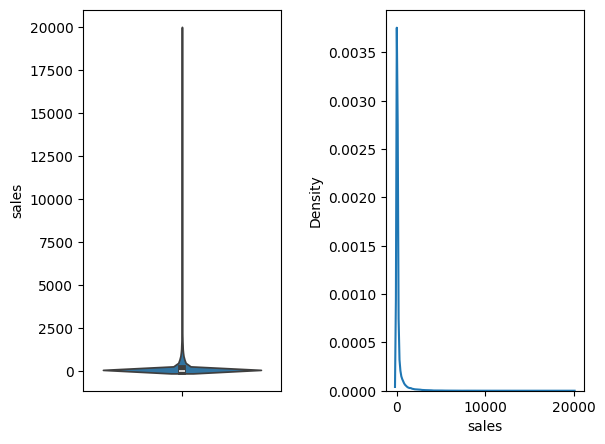

In [336]:
#Plotting the frequency of values vs the 
sales_basic_data_numerical_variables = ['sales']
fig, axs = plt.subplots(ncols=2)
for variable in sales_basic_data_numerical_variables:
    sns.violinplot(daily_sales_data[variable], ax=axs[0])
    sns.kdeplot(daily_sales_data[variable], ax=axs[1])
    sns.histplot(daily_sales_data[variable])
    px.
fig.tight_layout(pad=2)

In [347]:
sales_basic_data_categorical_variables = ['store_nbr']
for variable in sales_basic_data_categorical_variables:
    sns.displot(daily_sales_data[variable])
    plt.pie(daily_sales_data[variable])

KeyboardInterrupt: 

In [ ]:
#What data could be interesting?
#date vs sales

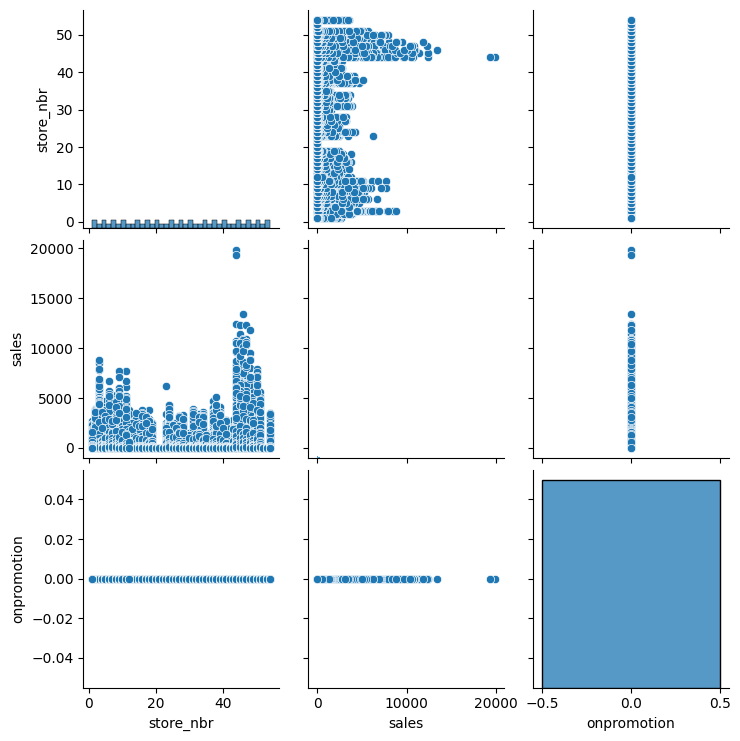

In [300]:
sns.pairplot(daily_sales_data)

# 3. Rename any unintuitive columns

In [13]:
train_dataset = FunctionTransformer(data_prep.rename_raw_dfs_cols).fit_transform(train_dataset)